=== TCC 2023 tract aggregation (CONUS) ===
Tracts: /mnt/sda-21.8/bdevoe/greenspace/resources/tracts/cb_2020_us_tract_500k.shp
Using TCC raster: /mnt/sda-21.8/bdevoe/greenspace/tcc/2023/nlcd_tcc_CONUS_2023_v2023-5_wgs84/nlcd_tcc_conus_wgs84_v2023-5_20230101_20231231.tif (priority=0)
Filtered to CONUS tracts: 83,509 of 85,187 (dropped 1,678)
Raster CRS: PROJCS["Albers_Conical_Equal_Area",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
Raster nodata: 255.0

=== Sanity checks ===
coun

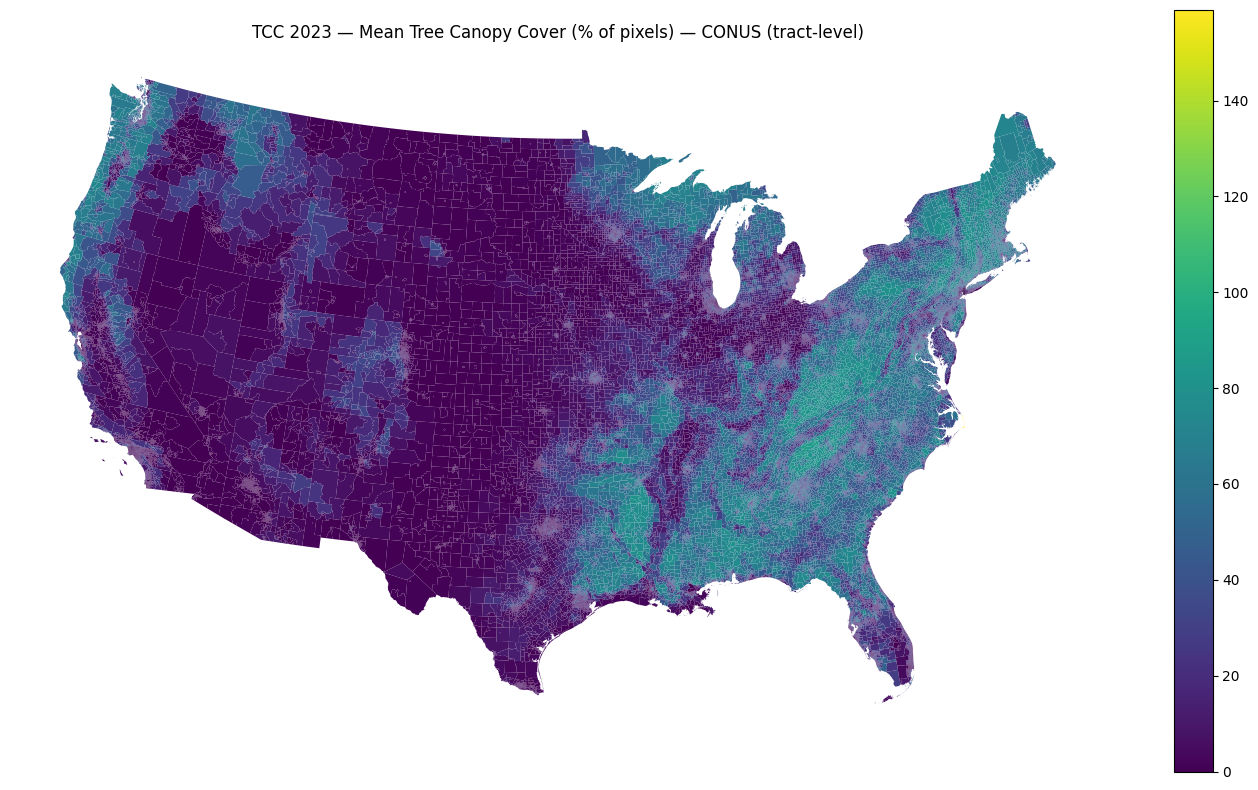


Wrote: /mnt/sda-21.8/bdevoe/greenspace/processed/tract_tcc_2023_cb2020_500k_CONUS.csv


In [1]:
# ============================================================
# TCC 2023 -> Census tract mean tree canopy cover (CONUS)
#  - Zonal mean of TCC raster within each 2020 census tract
#  - Output: GEOID, tcc_2023
# ============================================================

import warnings
warnings.filterwarnings("ignore")

from pathlib import Path
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
from rasterstats import zonal_stats
import matplotlib.pyplot as plt

# -------------------------
# 0) Config
# -------------------------
BASE = Path("/mnt/sda-21.8/bdevoe/greenspace")

TRACTS_SHP = BASE / "resources" / "tracts" / "cb_2020_us_tract_500k.shp"
TCC_ROOT   = BASE / "tcc"
YEAR       = 2023

# set False if you only want prints/maps
SAVE_CSV = True
OUT_CSV  = BASE / "processed" / f"tract_tcc_{YEAR}_cb2020_500k_CONUS.csv"

# -------------------------
# 1) Helpers
# -------------------------
def filter_to_conus(tracts: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    if "STATEFP" not in tracts.columns:
        raise ValueError("Expected STATEFP in cb_2020_us_tract_500k shapefile.")
    exclude = {"02", "15", "60", "66", "69", "72", "78"}  # AK, HI, AS, GU, MP, PR, VI
    statefp = tracts["STATEFP"].astype(str).str.zfill(2)
    return tracts.loc[~statefp.isin(exclude)].copy()

def find_tcc_raster(year: int) -> Path:
    """
    Prefer NLCD TCC; else science TCC. Choose largest valid tif that opens.
    """
    year_dir = TCC_ROOT / str(year)
    if not year_dir.exists():
        raise FileNotFoundError(f"TCC year directory not found: {year_dir}")

    candidates = []
    for sub in year_dir.iterdir():
        if not sub.is_dir():
            continue
        if "tcc_CONUS" not in sub.name:
            continue
        for tif in sub.glob("*.tif"):
            if tif.stat().st_size == 0:
                continue
            name = tif.name.lower()
            pri = 0 if "nlcd_tcc" in name else (1 if "science_tcc" in name else 2)
            candidates.append((pri, -tif.stat().st_size, tif))

    if not candidates:
        raise FileNotFoundError(f"No .tif candidates found under {year_dir}")

    candidates.sort()
    last_err = None
    for pri, _, tif in candidates:
        try:
            with rasterio.open(tif) as src:
                _ = src.crs
            print(f"Using TCC raster: {tif} (priority={pri})")
            return tif
        except Exception as e:
            last_err = e

    raise RuntimeError(f"Could not open any TCC raster for {year}. Last error: {last_err}")

# -------------------------
# 2) Load tracts + raster
# -------------------------
print(f"=== TCC {YEAR} tract aggregation (CONUS) ===")
print("Tracts:", TRACTS_SHP)
tcc_tif = find_tcc_raster(YEAR)

tracts = gpd.read_file(TRACTS_SHP)
if "GEOID" not in tracts.columns:
    raise ValueError("Tracts shapefile missing GEOID column.")

tracts = tracts[["GEOID", "STATEFP", "geometry"]].copy()
tracts = tracts[~tracts.geometry.is_empty & tracts.geometry.notnull()].copy()

n0 = len(tracts)
tracts = filter_to_conus(tracts)
print(f"Filtered to CONUS tracts: {len(tracts):,} of {n0:,} (dropped {n0-len(tracts):,})")

with rasterio.open(tcc_tif) as src:
    raster_crs = src.crs
    raster_nodata = src.nodata
    print("Raster CRS:", raster_crs)
    print("Raster nodata:", raster_nodata)

# reproject once to raster CRS
if tracts.crs != raster_crs:
    tracts = tracts.to_crs(raster_crs)

# -------------------------
# 3) Zonal mean
# -------------------------
zs = zonal_stats(
    vectors=tracts.geometry,
    raster=str(tcc_tif),
    stats=["mean"],
    nodata=raster_nodata,
    all_touched=False
)

tcc_mean = np.array([z["mean"] if z["mean"] is not None else np.nan for z in zs], dtype=float)

out = pd.DataFrame({
    "GEOID": tracts["GEOID"].astype(str).values,
    "tcc_2023": tcc_mean
})

print("\n=== Sanity checks ===")
print(out["tcc_2023"].describe())
print("non-missing:", out["tcc_2023"].notna().sum())

# -------------------------
# 4) Map (in-notebook)
# -------------------------
try:
    gmap = tracts[["GEOID", "geometry"]].copy()
    gmap = gmap.merge(out, on="GEOID", how="left")

    fig, ax = plt.subplots(1, 1, figsize=(14, 8))
    gmap.plot(column="tcc_2023", ax=ax, legend=True, linewidth=0, missing_kwds={"color": "lightgrey"})
    ax.set_title("TCC 2023 — Mean Tree Canopy Cover (% of pixels) — CONUS (tract-level)")
    ax.set_axis_off()
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("Map failed (non-fatal):", e)

# -------------------------
# 5) Optional save
# -------------------------
if SAVE_CSV:
    out.to_csv(OUT_CSV, index=False)
    print("\nWrote:", OUT_CSV)
else:
    print("\nSAVE_CSV=False (no file written).")
